In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopack import geopack
import pyspedas
import sys
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov

Load IGRF coefficients ...


In [2]:
#REPPU otuputs
#path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Data/pbig5min.dat'
#path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Data/pbig5min.dat'
path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Data/fbig5min.dat'

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [3]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [4]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'current': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add current and units
ds['current'].attrs['units'] = 'mA/m^2'
ds['current'] = ds['current'] * 1e6 #convert from A to uA
ds

<xarray.Dataset> Size: 440MB
Dimensions:  (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt       (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat      (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon      (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    current  (dt, lat, lon) float32 440MB 0.0 0.0 0.0 ... 0.1796 0.1782 0.1768

In [5]:
#open the omni data and merge it with the REPPU data
omni_mhd_path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/'

omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset> Size: 407MB
Dimensions:         (dt: 42158, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 337kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    current         (dt, lat, lon) float32 405MB 0.0 0.0 0.0 ... 0.1782 0.1768
    BY_GSE          (dt) float64 337kB 4.72 4.35 4.61 4.65 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 337kB 6.24 6.55 6.56 6.89 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 337kB 344.0 344.0 345.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 337kB 12.11 11.44 12.65 ... 8.03 7.08 6.84
    tilt_angle      (dt) float64 337kB 0.253 0.2497 0.2465 ... 0.2744 0.271

In [6]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [7]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, np.round(nan_ratio, 2)

#nan_count(ds_test, 'flow_speed')

In [8]:
#training
X_train = ds_train.drop_vars('current').to_array().values.T #drop the current and keep the rest
y_train = ds_train['current'].values
y_train = y_train.reshape(-1, 30*80) #flatten lat & lon

#testing
X_test = ds_test.drop_vars('current').to_array().values.T #drop the current and keep the rest
y_test = ds_test['current'].values
y_test = y_test.reshape(-1, 30*80) #flatten lat & lon

In [9]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 250 #number of reservoir neurons

#built, optimize and train model
#model = ESN(N_u = input_dim, N_y = output_dim, N_x=reservoir_size, density=0.1, input_scale=0.1, rho=0.99)
#optimizer = Tikhonov(N_u = input_dim, N_x = reservoir_size, N_y = output_dim, beta=1e-3)
#model.train(X_train, y_train, optimizer)

In [10]:
#save or load model
#with open('SMRAI2_current_SR.pkl', 'wb') as f:
#    pickle.dump(model, f)

with open('SMRAI2_current_SR.pkl', 'rb') as f:
    model = pickle.load(f)

In [11]:
#make prediction on text set and reshape to lat and lon again
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 30, 80)

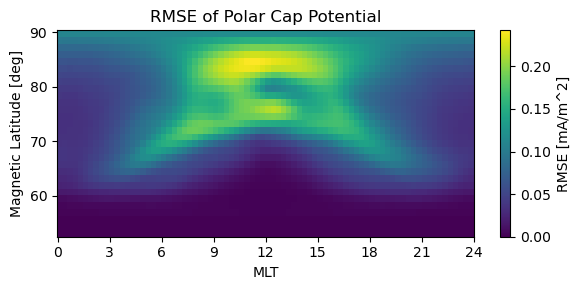

In [12]:
# Create prediction dataset
ds_pred = xr.Dataset({'current': (['dt', 'lat', 'lon'], y_pred)},
                coords={'dt': ds_test['dt'], 'lat': ds_test['lat'], 'lon': ds_test['lon']})

# Add current and units
ds_pred['current'].attrs['units'] = 'mA/m^2'
ds_pred = ds_pred.merge(ds_test.drop_vars('current'))

#calculate RMSE across all lat, lon
ds_pred['RMSE'] = np.sqrt((ds_pred['current'] - ds_test['current'])**2)
ds_pred['RMSE'].attrs['units'] = 'mA/m^2'

#convert long to mlt
ds_pred['lon'] = np.mod(ds_pred['lon'] / 15, 24) #convert lon to mlt
ds_pred

fig = plt.figure(figsize=(6,3))

#plot RMSE as radar plot
cbar = ds_pred['RMSE'].mean('dt').plot()
plt.title('RMSE of Polar Cap Potential')
plt.ylabel('Magnetic Latitude [deg]')
plt.xticks(np.arange(0, 25, 3))
plt.xlabel('MLT')

plt.tight_layout()
#plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/current/global-rmse_SMRAI2.png', dpi=300)

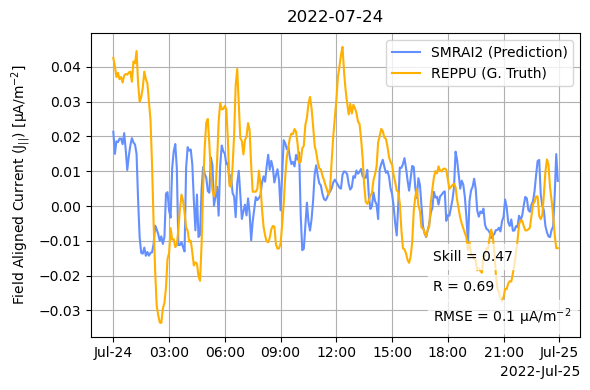

In [13]:

#2022-07-12 is worst
#2022-07-31 is okay
#2022-07-25 is best
#2022-07-29 is best
#2022-07-30 is best
date = '2022-07-24'


fig, ax = plt.subplots(figsize=(6, 4))
ds_pred['current'].sel(dt=date).mean(['lat', 'lon']).plot(label='SMRAI2 (Prediction)', color='#648FFF')
ds_test['current'].sel(dt=date).mean(['lat', 'lon']).plot(label='REPPU (G. Truth)', color='#FFB000')

rmse = np.sqrt(np.mean((ds_pred['current'].sel(dt=date).values - ds_test['current'].sel(dt=date).values)**2))
r = np.corrcoef(ds_pred['current'].sel(dt=date).values.flatten(), ds_test['current'].sel(dt=date).values.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  

skill_val = skill(ds_pred['current'].sel(dt=date).values, ds_test['current'].sel(dt=date).values)

ma = r'$\mathrm{\mu}$A/m$^{-2}$'
annotations = [
    (f'RMSE = {rmse:.1f} {ma}', (0.7, 0.05)),
    (f'R = {r:.2f}', (0.7, 0.15)),
    (f'Skill = {skill_val:.2f}', (0.7, 0.25))
]

for annotation, position in annotations:
    annot = plt.annotate(annotation, xy=position, xycoords='axes fraction')
    annot.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

plt.legend()
par = r'J$_{||}$'
plt.title(f'{date}',pad=8)
plt.xlabel(' ')
plt.ylabel(f'Field Aligned Current ({par}) [{ma}]')
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/rmse.png', dpi=300)

In [14]:
#loop through all dates in the test and pred dataset and calculate the RMSE then put into a df
rmse_list = []
#r_list = []
#skill_list = []
for date in ds_test['dt']:
    rmse = np.sqrt(np.mean((ds_pred['current'].sel(dt=date).values - ds_test['current'].sel(dt=date).values)**2))
    #r = np.corrcoef(ds_pred['potential'].sel(dt=date).values.flatten(), ds_test['potential'].sel(dt=date).values.flatten())[0, 1]
    #skill_val = skill(ds_pred['potential'].sel(dt=date).values, ds_test['potential'].sel(dt=date).values)
    rmse_list.append(rmse)
    #r_list.append(r)
    #skill_list.append(skill_val)

rmse_df = pd.DataFrame(rmse_list, columns=['RMSE'])
rmse_df['dt'] = ds_test['dt']

rmse_df['date'] = rmse_df['dt'].dt.date
rmse_df['hr'] = rmse_df['dt'].dt.hour
#rmse_df['Kp'] = ds_test['Kp'].values
rmse_df

,RMSE,dt,date,hr
0,0.069082,2022-07-11 15:05:00,2022-07-11,15
1,0.071920,2022-07-11 15:10:00,2022-07-11,15
2,0.080359,2022-07-11 15:15:00,2022-07-11,15
3,0.073671,2022-07-11 15:20:00,2022-07-11,15
4,0.077771,2022-07-11 15:25:00,2022-07-11,15
...,...,...,...,...
5577,0.178340,2022-07-31 23:35:00,2022-07-31,23
5578,0.184794,2022-07-31 23:40:00,2022-07-31,23
5579,0.158391,2022-07-31 23:45:00,2022-07-31,23
5580,0.080086,2022-07-31 23:50:00,2022-07-31,23


In [15]:
rmse_df.groupby('date').mean().sort_values(by='RMSE', ascending=True)

,RMSE,dt,hr
date,,,
2022-07-25,0.079654,2022-07-25 12:01:45.263157760,11.571930
2022-07-24,0.082772,2022-07-24 11:57:06.923076864,11.493007
2022-07-13,0.094510,2022-07-13 10:48:32.790697728,10.348837
2022-07-29,0.096229,2022-07-29 11:59:08.936169984,11.524823
2022-07-26,0.098255,2022-07-26 11:59:13.763440896,11.530466
2022-07-27,0.107765,2022-07-27 11:57:47.832167680,11.503497
2022-07-30,0.110489,2022-07-30 11:58:31.267605760,11.517606
2022-07-20,0.111115,2022-07-20 11:50:51.063829760,11.390071
2022-07-28,0.116131,2022-07-28 11:58:26.451612928,11.516129


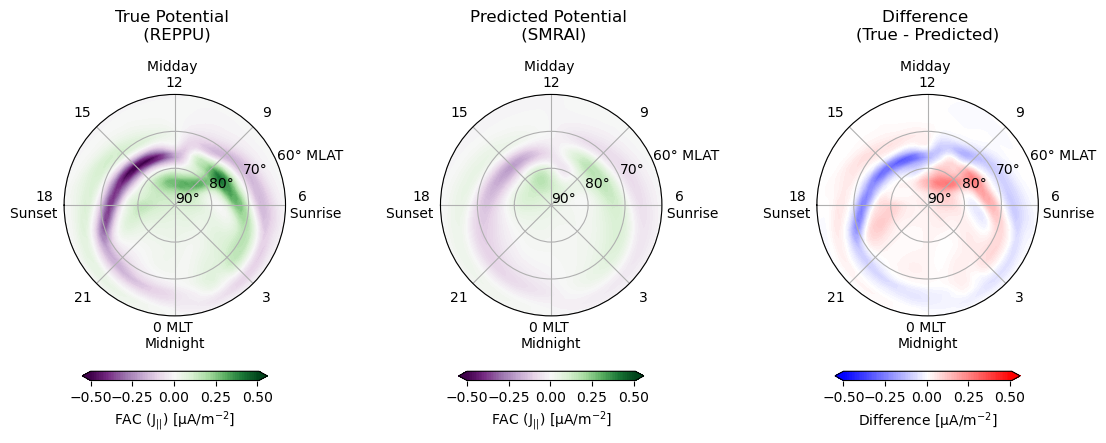

In [16]:
# Define the date
date = "2022-07-21"

# Extract true and predicted values
current_true = ds_test['current'].sel(dt=date).values[0]
current_pred = ds_pred['current'].sel(dt=date).values[0]

# Calculate the difference
diff = current_true - current_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4.5))

# Define radial and angular coordinates
theta = np.linspace(0, 360, 80) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 89.7, 30)

#common settings
shrink = .3
levels = np.linspace(-0.50, 0.50+0.01, 100)
c_pad = 0.17
t_pad = 15
ma = r'$\mathrm{\mu}$A/m$^{-2}$'
j_lab = r'J$_{||}$'
current_lab = f'FAC ({j_lab}) [{ma}]'

# Plot true values
c_true = axs[0].contourf(theta_rad, r, current_true, levels=levels, cmap='PRGn', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
axs[0].set_title(f'True Potential \n (REPPU)', pad=t_pad)
plt.colorbar(c_true, ax=axs[0], label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, current_pred, levels=levels, cmap='PRGn', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
axs[1].set_title(f'Predicted Potential \n (SMRAI)', pad=t_pad)
plt.colorbar(c_pred, ax=axs[1], label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5],  orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, diff, levels=levels, cmap='bwr', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
axs[2].set_title('Difference \n(True - Predicted)', pad=t_pad)
plt.colorbar(c_diff, ax=axs[2], label=f'Difference [{ma}]', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')

plt.subplots_adjust(wspace=-0.6)  # Adjust horizontal space between subplots

plt.tight_layout()
#plt.savefig('test_2', bbox_inches='tight', dpi=300)


In [20]:

# Select the date
date = "2022-07-21"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define radial and angular coordinates
theta = np.linspace(0, 360, 80) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 89.7, 30)

#common settings
shrink = .3
levels = np.linspace(-0.50, 0.50+0.01, 100)
c_pad = 0.17
t_pad = 15
ma = r'$\mathrm{\mu}$A/m$^{-2}$'
j_lab = r'J$_{||}$'
current_lab = f'FAC ({j_lab}) [{ma}]'


# Loop through each time step
for i, time in enumerate(times):

    current_true = ds_test['current'].sel(dt=date).values[i]
    current_pred = ds_pred['current'].sel(dt=date).values[i]

    # Calculate the difference
    c_diff = current_true - current_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4.5))

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, current_true, levels=levels, cmap='PRGn', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    axs[0].set_title(f'True Potential \n (REPPU)', pad=t_pad)
    plt.colorbar(c_true, ax=axs[0], label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, current_pred, levels=levels, cmap='PRGn', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    axs[1].set_title(f'Predicted Potential \n (SMRAI)', pad=t_pad)
    plt.colorbar(c_pred, ax=axs[1], label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5],  orientation='horizontal')

    c_diff = axs[2].contourf(theta_rad, r, diff, levels=levels, cmap='bwr', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    axs[2].set_title('Difference \n(True - Predicted)', pad=t_pad)
    plt.colorbar(c_diff, ax=axs[2], label=f'Difference [{ma}]', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')

    plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

    plt.tight_layout()

    #add the time to the plot
    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H-%M')
    plt.annotate(f'{str_time}', xy=(-1.45, -0.7), xycoords='axes fraction', fontsize=12)

    # Save the figure with the timestamp in the title
    plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/current/2022-07-21/current_plot_{str_time}.png', dpi=300, bbox_inches='tight')
    
    # Close the figure to free up memory
    plt.close(fig)

    #break after n interations
    if i in [10]:
        break

